# Maximum Likelihood Estimation and Exoplanet Transits
### 20250916 - ASTR 496: Foundations of Data Science in Astrophysics, Week 4
Todays' colloquium speaker, Prof. Cristobal Petrovich, studies exoplanet systems and how they form, migrate, and get into configurations like we see today. To check that his models work of course, he does need to see existing exoplanet systems. The way we find many of these systems is using NASA's TESS satellite and looking for "Transits" - when the planet moves in front of the star it orbits along our line of sight, and causes the light from that star to dim. 

We're going to prep for this by seeing if you can analyze an exoplanet transit from TESS (sorta) with a model that you infer the parameters of using maximum likelihood.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import requests
import io
from astropy.io import fits
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

In [8]:
%matplotlib ipympl
plt.style.use('seaborn-v0_8') #you don't need this - it just looks nicer IMO

RuntimeError: 'ipympl is not a recognised GUI loop or backend name

### First, if we are going to do maximum likelihood estimation, we are going to need some data 
### To do this, I'm going to give you a couple of functions - one to mock up the data
### Another to plot it
### After that, you are on your own - welcome to doing research
### The prompts are going to tell you what I'd like you to do, but how you do it is up to you

In [3]:
def download_tess_lightcurve(tic_id, sector):
    """
    Fake download TESS lightcurve data from MAST archive
    For this example, we'll simulate the download process and create realistic data instead
    based on known transit parameters of TOI-715 
    because when I'm doing this MAST is down for maintenance
    """
    # In practice, you would actually use:
    # from astroquery.mast import Observations
    # obs_table = Observations.query_criteria(target_name=f"TIC {tic_id}", obs_collection="TESS")

    # For this demonstration, we'll create realistic synthetic data
    # based on TOI-715 b parameters
    print(f"Simulating download of TIC {tic_id} data from TESS Sector {sector}")

    # Generate time array (TESS cadence is ~2 minutes)
    t_start = 2458000  # BJD
    duration = 27.4  # days (TESS sector length)
    cadence = 2.0/60/24  # 2 minutes in days
    time = np.arange(t_start, t_start + duration, cadence)

    # Known parameters for TOI-715 b (approximately)
    period = 19.28  # days
    t0 = t_start + 5.0  # transit center
    depth = 0.001  # transit depth (0.1%)
    duration_hrs = 2.8  # transit duration in hours

    # Generate synthetic lightcurve with realistic noise
    flux = np.ones_like(time)

    # Add transits
    transit_duration = duration_hrs / 24  # convert to days
    n_transits = int(duration / period) + 1

    for i in range(n_transits):
        tc = t0 + i * period
        if tc < time[-1]:
            # Simple box transit model
            in_transit = np.abs(time - tc) < transit_duration/2
            flux[in_transit] -= depth

    # Add realistic noise
    noise_level = 0.0002  # 200 ppm
    flux += np.random.normal(0, noise_level, len(flux))

    # Add some systematic trends (i.e. TESS artifacts - if you saw Zac Lane's journal club on Sep 15, 2025 you'll see this)
    flux += 0.0001 * np.sin(2*np.pi*time/1.5)  # Instrument systematics

    return time, flux

In [4]:
# (Fake) Download data for TOI-715 (TIC 142748283)
time, flux = download_tess_lightcurve(142748283, 42)
print(f"Downloaded {len(time)} data points")
print(f"Time range: {time[0]:.1f} to {time[-1]:.1f} BJD")

Simulating download of TIC 142748283 data from TESS Sector 42
Downloaded 19728 data points
Time range: 2458000.0 to 2458027.4 BJD


In [5]:
def plot_lightcurve(time, flux, title="TESS Lightcurve", plotstyle='ko', alpha=0.6, markersize=0.9, new=True):
    """Plot the full lightcurve"""
    if new:
        plt.figure()
        
    plt.plot(time - time[0], flux, plotstyle, alpha=alpha, markersize=markersize)
    
    if new:
        plt.xlabel('Time since start (days)')
        plt.ylabel('Relative TESS Flux')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()


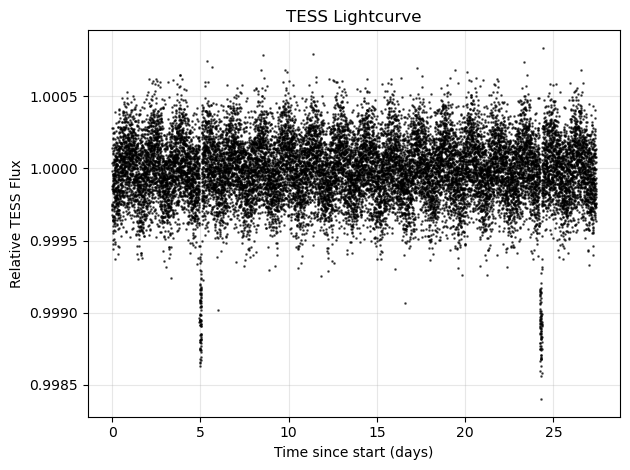

In [6]:
plot_lightcurve(time, flux)

### Again, if you were at journal club yesterday, you learned that TESS shows long-term systematics
### where the relative flux normalization bounces around a little as the space
### In our example, I mocked this up in the last line of code in the function
### One thing you'll have to do frequently in astro is make your data robust against such effects
### A simple way to do this is to "detrend" the data by median filtering it 
### i.e. replace the flux with the median of the flux in some window
### you can use the `median_filter` function from scipy.ndimage but you should implement the filtering
### Look particularly at the `size` argument to `median_filter` and ensure that it is always odd
### regardless of the `window_size` argument

In [58]:
def detrend_lightcurve(time, flux, window_size=1.0):
    """Simple detrending using median filtering"""
    from scipy.ndimage import median_filter

    ###### FILL THIS IN #####
    
    # Turn window size into something meaningful
    # Window size means days
    # Use np.diff instead of for loop
    diffLi = []
    for i in range(len(time)-1):
        diff = time[i+1] - time[i]
        diffLi.append(diff)
    intervalSec = np.mean(diffLi)
    intervalSec = np.median(np.diff(time))
    intervalHour = intervalSec*(1/60)

    if window_size % 2 == 0:
        window_size += 1

    detrended_flux=median_filter(flux, size = 3)
    return detrended_flux

In [57]:
5 % 2

1

In [51]:
flux_detrended = detrend_lightcurve(time, flux, window_size=15)
flux_detrended

np.float64(0.00138888880610466)

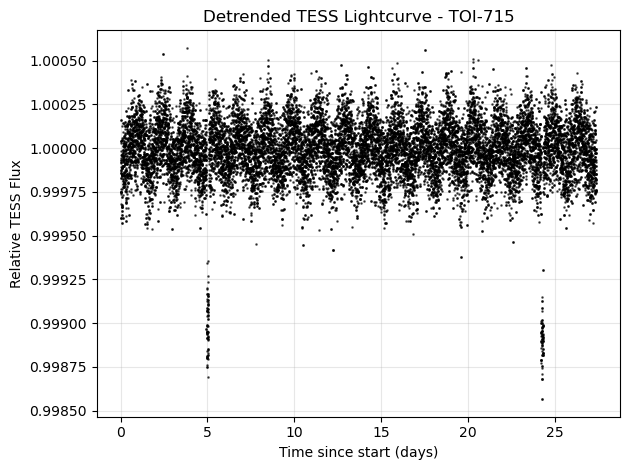

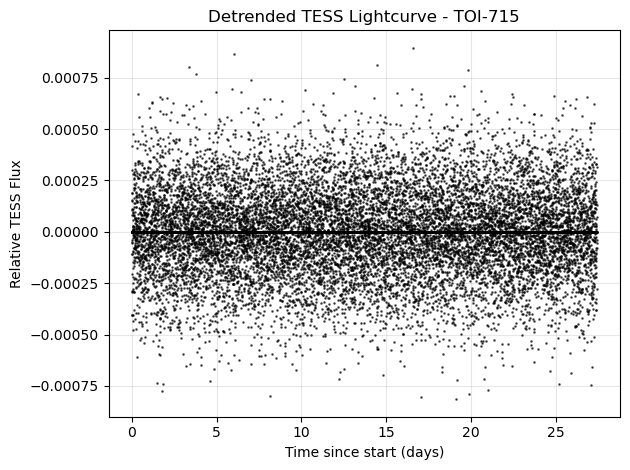

In [46]:
# Detrend the data and plot the detrended light curve and the difference between the detrended and original light curve
# call the variable you return `flux_detrended`
# try a window_size of 15 but you can also rerun this cell with different sizes

flux_detrended = detrend_lightcurve(time, flux, window_size=15)
plot_lightcurve(time, flux_detrended, "Detrended TESS Lightcurve - TOI-715", plotstyle='ko')
plot_lightcurve(time, flux_detrended-flux,  "Detrended TESS Lightcurve - TOI-715", plotstyle='ko')

### It is a good idea to get a sense for the noise in the data - since we didn't simulate errors on the measurements
### we can look at the scatter of the observations - they're all close in time and fairly consistent with a baseline
### so this is not a bad thing to do

In [59]:
# Estimate noise level
noise_estimate = np.std(flux_detrended)
print(f"Estimated noise level: {noise_estimate:.6f} ({noise_estimate*1e6:.0f} ppm)")

Estimated noise level: 0.000000 (0 ppm)


### Next we need a model
### We'll adapt one from Mandel and Agol 2002 (https://ui.adsabs.harvard.edu/abs/2002ApJ...580L.171M/abstract)
### This was largely work by my friend and colleague, Kaisey Mandel (https://www.ast.cam.ac.uk/people/kaisey.mandel) 
### ... who did this work as an undergraduate...  
### so you can whine about the challenge here, from this particular problem
### or you could have come up with the framework and been cited over 2000 times. 

In [60]:
def transit_model(time, params):
    """
    Simple analytical transit model (Mandel & Agol approximation for small planets)

    Parameters:
    - params[0]: t0 (transit center time)
    - params[1]: period (orbital period)
    - params[2]: depth (transit depth, (Rp/Rs)^2)
    - params[3]: duration (transit duration in days)
    - params[4]: baseline (out-of-transit flux level)
    """
    t0, period, depth, duration, baseline = params

    # Calculate phase
    phase = ((time - t0) % period) / period
    # Center phase around transit
    phase = np.where(phase > 0.5, phase - 1, phase)

    # Simple box model (can be replaced with more sophisticated models e.g. including limb darkening)
    transit_width = duration / period / 2  # Half duration in phase units
    in_transit = np.abs(phase) < transit_width

    model_flux = np.full_like(time, baseline)
    model_flux[in_transit] = baseline - depth

    return model_flux

### So now you have the data, $D$, i.e. `time` and `detrended_flux`
### and the model specified with the parameters, $\theta$, i.e. `params`

ValueError: x and y must have same first dimension, but have shapes (19728,) and (1,)

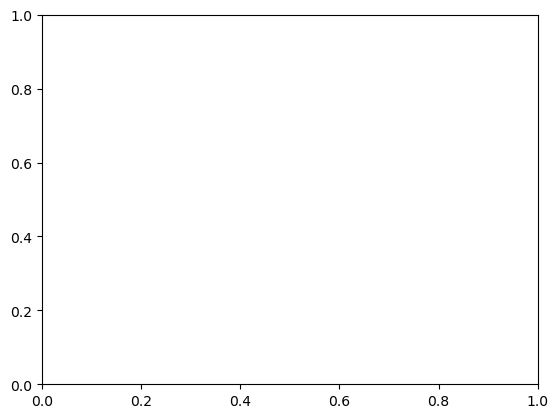

In [61]:
# Test the transit model - since I'm basing this example on TOI-715 b parameters, I can just plot the model
test_params = [2458005.0, 19.28, 0.001, 2.8/24, 1.0]  # t0, period, depth, duration, baseline
test_model = transit_model(time, test_params)

plot_lightcurve(time, flux_detrended,"Detrended TESS Lightcurve - TOI-715", plotstyle='ko')
plot_lightcurve(time, test_model, "Detrended TESS Lightcurve - TOI-715", plotstyle='r-', alpha=1.0, new=False)

In [62]:
# You can also zoom in on first transit to get a closer look at the model e.g. 
plt.figure()
transit_mask = np.abs(time - test_params[0]) < 0.2
plt.plot(time[transit_mask] - time[0], flux_detrended[transit_mask], 'ko', markersize=2, label='Data')
plt.plot(time[transit_mask] - time[0], test_model[transit_mask], 'r-', linewidth=2, label='Model')
plt.xlabel('Time since start (days)')
plt.ylabel('Relative Flux')
plt.legend()
plt.title('Zoomed Transit')
plt.tight_layout()
plt.show()

IndexError: invalid index to scalar variable.

<Figure size 640x480 with 0 Axes>

### Now the work begins
### Assume that the uncertainties from TESS are Gaussian
### Define a `log_likelihood` finction i.e. $-\frac{1}{2}\chi^2$ 
### (you may also wish to define the negative `log_likelihood` function for `scipy.optimize`)
### Here, I am specifying the likelihood function and relating it to chi-squared, but rememeber you have some freedom here
### While we aren't being fully Bayesian yet, it helps to define bounds for our optimizer - this is effectively a prior
### Wrote down a `log_prior` function with some reasonable values 
### (remember you are the researcher - this is your experiment - you pick this)
### Finally, define the `log_posterior` function (remember Bayes' theorem)

In [91]:
def log_likelihood(params, time, flux, flux_err=None):
    """
    Calculate log-likelihood for transit model parameters
    Assumes Gaussian errors
    """
    ##### FILL THIS IN #####
    # Chi-squared = sum of (flux - model)^2 all over sum of variance
    # log_likelihood = -1/2 * chi-squared
    from scipy.stats import chisquare
    if flux_err is None:
        flux_err = np.std(flux)*0.1
    model = transit_model(time, params)
    return (-1/2)*np.sum((flux - model)**2) / flux_err**2
    # return chisquare(flux, transit_model)

def neg_log_likelihood(params, time, flux, flux_err=None):
    """Negative log-likelihood for minimization"""
    return -log_likelihood(params, time, flux, flux_err)

def log_prior(params):
    """
    Prior probability distributions for parameters
    Assumes uniform priors within reasonable bounds
    """
    t0, period, depth, duration, baseline = params
    ##### FILL THIS IN #####
    return 0  # Uniform prior (log(1) = 0)


def log_posterior(params, time, flux, flux_err=None):
    """Log posterior probability"""
    ##### This is a freebie but hey FILL THIS IN #####

In [93]:
log_likelihood(test_params, time, flux)

np.float64(-819385.4579608903)

### Now, use `scipy.optimize.minimize` to solve for the maximum likelihood estimate 
### First use the `Nelder-Mead` method to get an initial solution fast with a maximum of 10,000 iterations
### Then, using the results of this optimization, run the `L-BFGS-B` method to calculate the matrix of the second derivates at the minimum
### This is called the "Hessian"
### The sqrt of the diagonal elements on the inverse of the Hessian is your error estimates

In [ ]:
def find_mle_parameters(time, flux, initial_guess, flux_err=None):
    """
    Find maximum likelihood estimates using scipy.optimize
    """
    print("Starting MLE optimization...")
    print(f"Initial guess: {initial_guess}")

    results = None
    mle_params = None
    # Use negative log-likelihood for minimization
    ##### FILL THIS IN #####
    result = minimize(neg_log_likelihood, initial_guess, args=(time, flux, flux_err), method = 'Nelder-Mead')
    mle_params = result.x

    param_errors = None
    # Calculate uncertainties using the Hessian
    ##### FILL THIS IN #####
    # param_errors = some function you call 
    minimized = minimize(flux, method='Nelder-Mead')
    Hessian = minimize(neg_log_likelihood, initial_guess, args=(time, flux, flux_err), method = 'L-BFGS-B')
    



    return mle_params, param_errors, result        

In [101]:
# I'll give you some initial guesses

# Initial parameter guess based on visual inspection
initial_params = [
    2458005.0,  # t0 (transit center)
    19.3,       # period (days)
    0.001,      # depth
    0.12,       # duration (days, ~2.8 hours)
    1.0         # baseline
]

In [102]:
# Run MLE optimization
##### FILL THIS IN #####
# mle_params, param_errors, result = something you call 

if mle_params is not None:
    param_names = ['t0 (BJD)', 'Period (days)', 'Depth', 'Duration (days)', 'Baseline']

    print("\n" + "="*50)
    print("MAXIMUM LIKELIHOOD ESTIMATION RESULTS")
    print("="*50)

    for i, (name, value, error) in enumerate(zip(param_names, mle_params, param_errors)):
        if np.isnan(error):
            print(f"{name:15s}: {value:10.6f}")
        else:
            print(f"{name:15s}: {value:10.6f} ± {error:10.6f}")

    print(f"\nLog-likelihood: {-result.fun:.2f}")

    # Calculate derived parameters
    if mle_params[2] > 0:  # depth > 0
        planet_radius_ratio = np.sqrt(mle_params[2])
        print(f"Planet/Star radius ratio: {planet_radius_ratio:.4f}")

NameError: name 'mle_params' is not defined

### Plot the Best Fit Model and the light curve 
### Using the period you found, fold the light curve (you should know what this is from 310) 
### and plot the phase-folded light curve and model
### Plot the residuals to the model 
### (you can use the `plot_lightcurve` function for all of these - this is why you use functions) 

In [ ]:
def plot_results(time, flux, mle_params, title="MLE Fit Results"):
    """Plot the data with best-fit model"""
    residuals = None
    #### first get the best fit model ####
    # best_model = some function you call 
    #### then calculate the residuals 
    # residuals = fill this sin 

    #### Plot the light curve and hte model 
    ##### FILL THIS IN #####
    
    #### calculate and plot the phase-folded transit (skip if running low on time)
    ##### FILL THIS IN #####
    
    #### Plot the Residuals
    ##### FILL THIS IN #####
    return residuals

if mle_params is not None:
    residuals = plot_results(time, flux_detrended, mle_params)

### Print the reduced chi-squared of the fit and if it is Good (< 1.5), Reasonable (< 3) or crap (>=3)

In [ ]:
if mle_params is not None:

    ##### FILL THIS IN #####

### There is a way to get more robust errors using a process called Bootstrapping, which we will cover on Thursday
### For now, if you can run the optimization, you should be able to get results that are useful
### We know some of the parameters of the star TOI-715 (How? We'll you'll find out on your midterm!) 
### Here's a function that will take your results `mle_params` and a dictionary for the `stellar_properties` 
### And prints out physical properties
### Note - These are simplified calculations. 
### Full analysis would require stellar parameters and limb darkening.

In [ ]:
def physical_interpretation(mle_params, stellar_properties=None):
    """
    Convert fitted parameters to physical quantities
    """
    t0, period, depth, duration, baseline = mle_params

    print("\n" + "="*60)
    print("PHYSICAL INTERPRETATION OF RESULTS")
    print("="*60)

    # Basic transit properties
    print(f"Orbital Period: {period:.3f} days ({period*24:.1f} hours)")
    print(f"Transit Duration: {duration*24:.2f} hours")
    print(f"Transit Depth: {depth:.6f} ({depth*100:.4f}%)")

    # Planet-to-star radius ratio
    if depth > 0:
        Rp_Rs = np.sqrt(depth)
        print(f"Planet/Star Radius Ratio (Rp/Rs): {Rp_Rs:.4f}")

        # If stellar radius is known, calculate planet radius
        if stellar_properties and 'R_star' in stellar_properties:
            R_star = stellar_properties['R_star']  # Solar radii
            R_planet_jupiter = Rp_Rs * R_star * 9.73  # Jupiter radii (1 R_sun ≈ 9.73 R_jup)
            R_planet_earth = R_planet_jupiter * 11.2  # Earth radii

            print(f"Planet Radius: {R_planet_jupiter:.2f} R_Jupiter")
            print(f"Planet Radius: {R_planet_earth:.1f} R_Earth")

    # Impact parameter estimate (simplified)
    if duration > 0 and period > 0:
        # Approximate formula for circular orbit
        a_Rs = ((period * 24 * 3600)**2 * 6.67e-11 * 1.989e30 / (4 * np.pi**2))**(1/3) / 6.96e8
        if stellar_properties and 'M_star' in stellar_properties:
            M_star = stellar_properties['M_star']  # Solar masses
            a_Rs *= M_star**(1/3)

        # Transit duration gives constraint on impact parameter
        print(f"Semi-major axis (approx): {a_Rs:.1f} R_star")

    

# Example stellar properties for TOI-715
stellar_props = {
    'R_star': 0.64,  # Solar radii (M dwarf)
    'M_star': 0.63   # Solar masses
}

if mle_params is not None:
    physical_interpretation(mle_params, stellar_props)